In [ ]:
# pip install evidently

In [139]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt

from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset, DataQualityPreset, ClassificationPreset

In [ ]:
"""

dataset = 'Intermediate_data/baseline_v1.csv'
model_name = 'baseline_xgboost.pkl'

dataset = 'Intermediate_data/trade&service_baseline_v1.csv'
model_name = 'trade&service_baseline_xgboost.pkl'

dataset = 'Intermediate_data/tech_baseline_v1.csv'
model_name = 'tech_baseline_xgboost.pkl'

dataset = 'Intermediate_data/multi_portfolio_baseline_v1.csv'
model_name = 'multi_portfolio_baseline_xgboost.pkl'

dataset = 'Intermediate_data/manufacture_baseline_v1.csv'
model_name = 'manufacture_baseline_xgboost.pkl'

"""

In [190]:
class CONFIG:
    dataset = 'Intermediate_data/multi_portfolio_baseline_v1.csv'
    model_name = 'multi_portfolio_baseline_xgboost.pkl'
    train_start = '2000-01-01'
    train_end = '2016-12-31'
    test_end = '2023-12-31'

In [191]:
df = pd.read_csv(CONFIG.dataset,index_col=0)

In [192]:
X_train = df.loc[CONFIG.train_start:CONFIG.train_end,:].drop('Signal',axis=1)
y_train = df.loc[CONFIG.train_start:CONFIG.train_end,'Signal']
X_test = df.loc[CONFIG.train_end:CONFIG.test_end,:].drop('Signal',axis=1)
y_test = df.loc[CONFIG.train_end:CONFIG.test_end,'Signal']

In [193]:
model = xgb.XGBClassifier(objective='multi:softmax')

param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5],
    'n_estimators': [100, 200, 300],
    'gamma':[0.1,0.2,0.3],
    'reg_lambda':[0.1, 0.2,0.3],
}

grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           cv=3)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

In [194]:
accuracy_score(best_model.predict(X_test),y_test)

0.4588235294117647

In [195]:
best_model.predict(X_test)

array([2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 0, 2, 2, 0, 2, 1,
       1, 2, 2, 2, 2, 2, 1, 1, 0, 0, 1, 2, 1, 2, 1, 2, 2, 1, 0, 0, 0, 0,
       0, 2, 0, 0, 2, 2, 0, 2, 2, 1, 0, 2, 1, 2, 2, 0, 2, 1, 0, 0, 0, 0,
       0, 2, 0, 2, 0, 0, 0, 1, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 1],
      dtype=int32)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

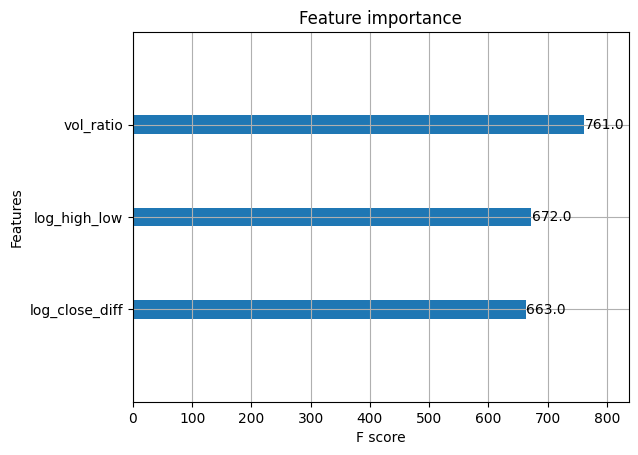

In [196]:
xgb.plot_importance(best_model)

In [197]:
reference = df.loc[CONFIG.train_start:CONFIG.train_end,:]
current = df.loc[CONFIG.train_end:CONFIG.test_end,:]
reference.rename(columns={'Signal':'target'},inplace=True)
current.rename(columns={'Signal':'target'},inplace=True)
reference['prediction'] = best_model.predict(X_train)
current['prediction'] = best_model.predict(X_test)

classification_report = Report(metrics=[
    ClassificationPreset()
])
classification_report.run(current_data=current, reference_data=reference)
classification_report.save_html(f'ML_Reports/{CONFIG.model_name}.html')

In [198]:
import pickle

model_path = f'Models/{CONFIG.model_name}'

# Save the model using pickle
with open(model_path, 'wb') as file:
    pickle.dump(best_model, file)

In [86]:
# # Load the model using pickle
# with open(model_path, 'rb') as file:
#     model = pickle.load(file)

In [199]:
import shap